In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib

import sys
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

data = pd.read_csv('faces.csv')

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:100].T
Y_dev = data_dev[2]
X_dev = data_dev[4:n]
X_dev = X_dev / 255.

data_train = data[1000:1500].T
Y_train = data_train[2]
X_train = data_train[4:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [3]:
print(X_train.shape)
print(_)
side_length = int(sqrt(_))
print(side_length)

(2304, 500)
2304
48


In [4]:
def visualize(image):
    side_length = int(np.sqrt(image.shape[0]))
    current_image = image.reshape((side_length, side_length)) * 255
    current_image = np.asarray(current_image, dtype = np.float64)
    plt.gray()
    plt.imshow(X=current_image, interpolation='nearest', cmap='gray')
    plt.show()

0


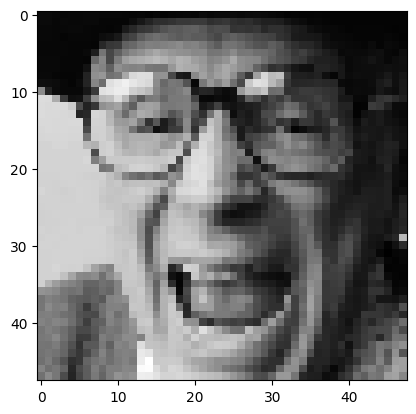

In [5]:
print(Y_train[251])
visualize(X_train.T[251])

Layers:
2304 node input layer
4 correlational layers, each 2025 nodes 

In [6]:
edge_detecting_kernels = [
    np.array([[1, -1, -1],
              [0, 1, -1],
              [0, 0, 1]]),
    
    np.array([[-1, -1, 1],
              [-1, 1, 0],
              [1, 0, 0]]),
    
    np.array([[-1, -1, -1],
              [1, 1, 1],
              [0, 0, 0]]),
    
    np.array([[0, 1, -1],
              [0, 1, -1],
              [0, 1, -1]])
]

# not being used on account of convolution processing not working at all
def rotate_180_degrees(kernel): # used to go from correlation to convolution!
    new_matrix = np.zeros((3,3), dtype=int)
    for i in range(3):
        for j in range(3):
            new_matrix[i, j] = kernel[2-i, 2-j]
    return new_matrix

In [7]:
# I will need to reduce the size of the images due to processing constraints
def reduce(image):
    image = image
    visualize(image)
    new_image = np.array([])

    kernel_side_length = 3
    pixel_step = kernel_side_length
    image_side_length = int(sqrt(image.shape[0])) # assuming image is square, just take sqrt of total pixels
    image = image.reshape((image_side_length, image_side_length))
    
    
    for i in range(0, image_side_length, pixel_step):
        for j in range(0, image_side_length, pixel_step):
            
            reduced_value = 0
            values = []
            for k in range(kernel_side_length):
                for l in range(kernel_side_length):
                    values.append(
                        image[i + k, j + l]
                    )
            
            reduced_value = max(values, key=abs)            
            new_image = np.append(new_image, reduced_value)
            
    return new_image

def correlate(index):
    left_diagonal_image = np.array([])
    right_diagonal_image = np.array([])
    horizontal_image = np.array([])
    vertical_image = np.array([])
    
    current_image = X_train.T[index]
    for i in range(side_length - 3): # 48 pixels per row - 3 to get last area checked by kernel
        for j in range(side_length - 3):
            checked_area = np.array([current_image[i * side_length + j:i * side_length + j + 3],
                                     current_image[(i + 1) * side_length + j:(i + 1) * side_length + j + 3],
                                     current_image[(i + 2) * side_length + j:(i + 2) * side_length + j + 3]])
            
            sum = [0, 0, 0, 0, 0, 0, 0, 0] # used to store temp pixel values for edge detection maps
            for k in range(3):
                for l in range(3):
                    for m in range(4):
                        sum[m] += checked_area[k, l] * edge_detecting_kernels[m][k, l] / 3
                    
                    
            left_diagonal_image = np.append(left_diagonal_image, sum[0])
            right_diagonal_image = np.append(right_diagonal_image, sum[1])
            horizontal_image = np.append(horizontal_image, sum[2])
            vertical_image = np.append(vertical_image, sum[3])
    
    left_diagonal_image = left_diagonal_image.reshape((45, 45))
    right_diagonal_image = right_diagonal_image.reshape((45, 45))
    vertical_image = vertical_image.reshape((45, 45))
    horizontal_image = horizontal_image.reshape((45, 45))
    
    temp_top = np.concatenate((left_diagonal_image, right_diagonal_image), axis=1)
    temp_bottom = np.concatenate((vertical_image, horizontal_image), axis=1)
    full_edge_image = np.concatenate((temp_top, temp_bottom), axis=0)
    full_edge_image = full_edge_image.flatten()

    return full_edge_image
    
new_edge_image = correlate(251)
print(new_edge_image.shape)

(8100,)


In [8]:
new_X_train = np.array(correlate(0))
length_of_image = new_X_train.size

for i in range(1, X_train.shape[1]):
    next_column = np.array(correlate(i))
    new_X_train = np.concatenate((new_X_train, next_column), axis=None)

new_X_train = new_X_train.reshape((length_of_image, X_train.shape[1]))
m, n = new_X_train.shape

Now we will initialize the NN and begin forward propagation

In [9]:
print(new_X_train[:5, :5])
print(new_X_train.size)
print(new_X_train.shape)

[[-0.00784314 -0.06143791 -0.05882353 -0.0496732  -0.02875817]
 [ 0.01960784  0.00392157 -0.00784314 -0.00522876  0.02091503]
 [-0.06797386 -0.06143791 -0.0379085   0.03921569  0.05620915]
 [-0.02352941  0.00784314 -0.07973856 -0.05751634  0.00130719]
 [-0.02614379 -0.06535948 -0.06928105 -0.02745098  0.01437908]]
4050000
(8100, 500)


In [10]:
def init():
    W1 = np.random.rand(10, 8100) - .5
    b1 = np.random.rand(10, 1) - .5
    W2 = np.random.rand(2, 10) - .5
    b2 = np.random.rand(2, 1) - .5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def sigmoid(Z):
    sig = 1 / (1 + np.exp(-Z))
    return sig

def softmax(Z):
    soft = np.exp(Z) / sum(np.exp(Z))
    return soft

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [11]:
# Back propagation and parameter updating

def ReLU_derivative(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T
    
def backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_derivative(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [14]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations): #, W1, b1, W2, b2):
    W1, b1, W2, b2 = init()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(new_X_train, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [15]:
W1, b1, W2, b2 = gradient_descent(new_X_train, Y_train.astype(int), .1, 10000) #, W1, b1, W2, b2)
pass

Iteration:  0
[0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0
 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1
 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0
 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0
 0 0 0 0 0 

The network finds the correct gender on the training faces ~70% of the time.